# GTEx V7 genotype data imputation
The official release currently does not impute missing data. We use Michigan Imputation Server for the task.

In [ ]:
[global]
genotype = "~/Documents/GTEx/gtex7/variant_calls/GTEx_Analysis_2016-01-15_v7_WholeGenomeSeq_635Ind_PASS_AB02_GQ20_HETX_MISS15_PLINKQC.PIR.vcf.gz"
cwd = "~/Documents/GTEx"

[plink: provides = executable('plink')]
# Download and extract plink2
output: os.path.join(cwd, "bin/plink")
task: workdir = cwd
download:
  https://www.cog-genomics.org/static/bin/plink170509/plink_linux_x86_64.zip
run:
  unzip -o plink_linux_x86_64.zip plink
  mv plink bin/plink
  rm -f plink_linux_x86_64.zip

[minimac3: provides = executable('Minimac3')]
# Download and extract minimac3
# Chosen over impute2 because of results shown here
# But is not needed: turns out the imputation server works great!
# McCarthy, Shane, et al. "A reference panel of 64,976 haplotypes for genotype imputation." Nature genetics (2016).
output: os.path.join(cwd, "bin/Minimac3")
task: workdir = cwd
download:
  https://github.com/Santy-8128/Minimac3/archive/master.zip
run:
  unzip master.zip
  cd Minimac3-master
  make
  mv bin/* ../bin
  cd ../
  rm -rf master.zip Minimac3-master


## Genotype missingness summary
Code below calculates missing rate by loci and by individuals. Plots are made to summarize the results.

In [ ]:
[summary_1]
# make summary statistics of genotype data
depends: executable("plink")
input: "${genotype!a}"
output: "${cwd!a}/genotype_missing/${input!bnn}.imiss.gz", "${cwd!a}/genotype_missing/${input!bnn}.lmiss.gz"
task: workdir = "${cwd!a}"
run:
    plink --vcf ${input} --missing gz --memory 30000 --threads 8 --out ${output[0]!nn}

[summary_2]
# making genotype summary statistics plot
depends: Py_Module("seaborn")
input: group_by = 1, pattern = "{name}.{ext}"
output: expand_pattern("{_name}.pdf")
task: workdir = "${cwd!a}"
run:
   zcat ${_input} | awk '{print $NF}' > ${_input}.fmiss.tmp
python:
import os
import matplotlib.pyplot as plt, seaborn as sns, pandas as pd
fig, axs = plt.subplots(ncols=2)
data = pd.read_csv("${_input}.fmiss.tmp", sep = '\t')
sns.distplot(data["F_MISS"], ax = axs[0], kde = False)
sns.violinplot(data["F_MISS"], ax = axs[1])
axs[0].set_title("Missing rate summary")
fig.savefig(${_output!r})
os.remove("${_input}.fmiss.tmp")

[summary_3]
# Save summary data to PNG in local folder
input: group_by = 1
output: "img/${_input[0]!bn}.png"
run:
    convert -density 200 ${_input} ${_output}

In [ ]:
%sosrun summary -b ~/Documents/GTEx/bin

> img/GTEx_Analysis_2016-01-15_v7_WholeGenomeSeq_635Ind_PASS_AB02_GQ20_HETX_MISS15_PLINKQC.PIR.lmiss.png (17.2 KiB):

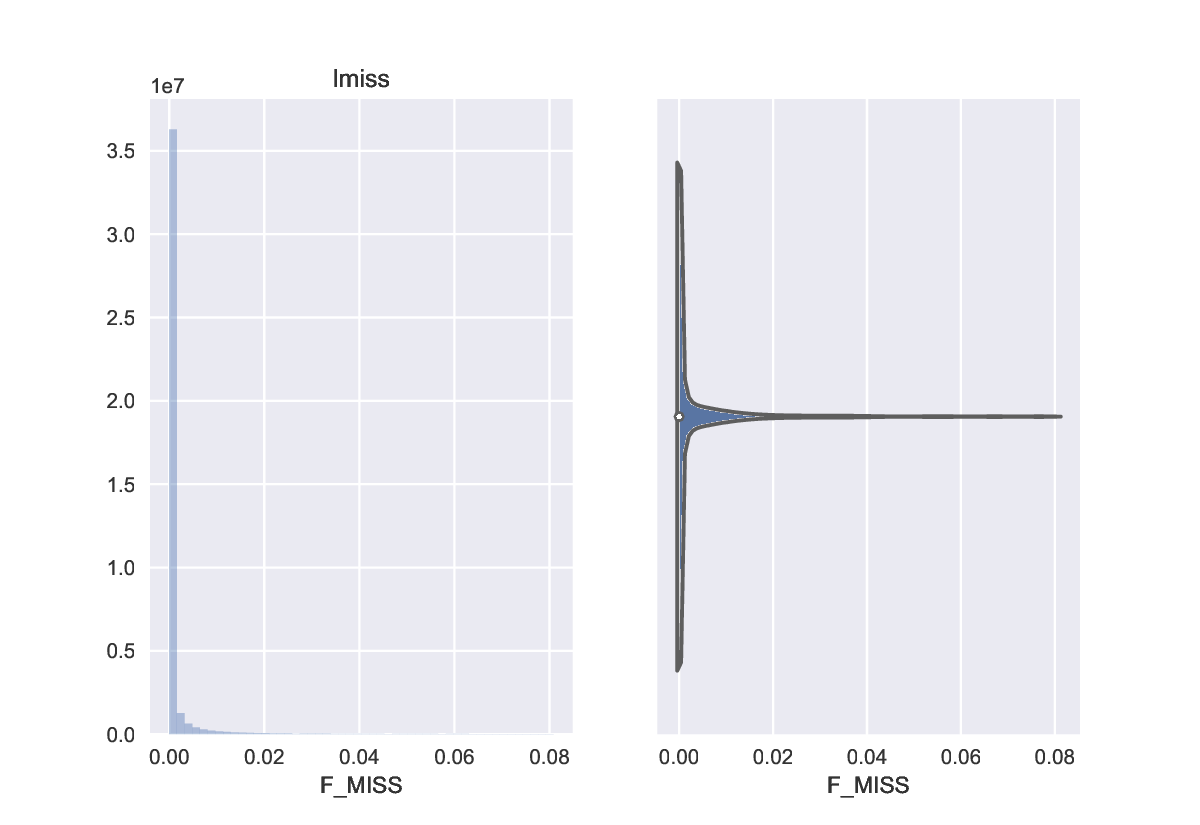

> img/GTEx_Analysis_2016-01-15_v7_WholeGenomeSeq_635Ind_PASS_AB02_GQ20_HETX_MISS15_PLINKQC.PIR.imiss.png (21.2 KiB):

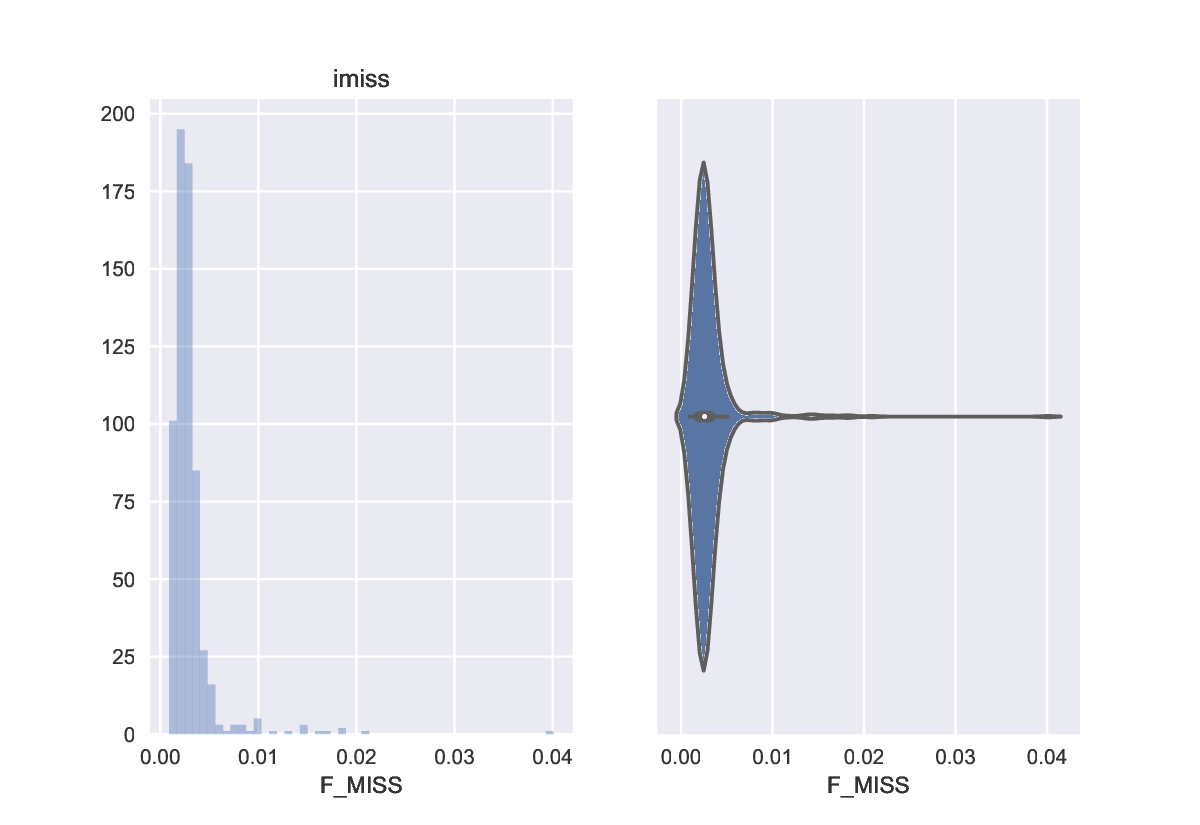

In [1]:
%preview img/GTEx_Analysis_2016-01-15_v7_WholeGenomeSeq_635Ind_PASS_AB02_GQ20_HETX_MISS15_PLINKQC.PIR.imiss.png
%preview img/GTEx_Analysis_2016-01-15_v7_WholeGenomeSeq_635Ind_PASS_AB02_GQ20_HETX_MISS15_PLINKQC.PIR.lmiss.png

Missing rates are mostly under 1%. This should make imputation relatively straightforward.

## Data processing for imputation server
Imputation server requires VCF input, by chromosome, each with complete header info. Code chunk below prepares input VCF file for UMich Imputation Server.

In [2]:
[prepare_1]
# split vcf by chroms
parameter: chrom = [x + 1 for x in range(22)] + ['X'] # there is in fact no Y chrom
input: "${genotype!a}", for_each = ['chrom']
output: ["${cwd!a}/genotype_by_chrom/${input!bnn}.chr{}.vcf.gz".format(x) for x in chrom], group_by = 1
task: workdir = "${cwd!a}"
run:
  tabix ${input} ${_chrom} --print-header | bgzip > ${_output}

In [3]:
%sosrun prepare -J8

"<i id=""status_localhost_ab213ede13dd94ac43ed2c7ec7fdf7fd"" class=""fa fa-2x fa-fw fa-square-o"" onmouseover=""$('#status_localhost_ab213ede13dd94ac43ed2c7ec7fdf7fd').addClass('fa-stop').removeClass('fa-square-o')"" onmouseleave=""$('#status_localhost_ab213ede13dd94ac43ed2c7ec7fdf7fd').addClass('fa-square-o').removeClass('fa-stop')"" onclick=""kill_task('ab213ede13dd94ac43ed2c7ec7fdf7fd', 'localhost')"" >",ab213ede13dd94ac43ed2c7ec7fdf7fd,,0 sec


"<i id=""status_localhost_8c1b9a0bd56717f5642e2b213885c8cd"" class=""fa fa-2x fa-fw fa-square-o"" onmouseover=""$('#status_localhost_8c1b9a0bd56717f5642e2b213885c8cd').addClass('fa-stop').removeClass('fa-square-o')"" onmouseleave=""$('#status_localhost_8c1b9a0bd56717f5642e2b213885c8cd').addClass('fa-square-o').removeClass('fa-stop')"" onclick=""kill_task('8c1b9a0bd56717f5642e2b213885c8cd', 'localhost')"" >",8c1b9a0bd56717f5642e2b213885c8cd,,0 sec


"<i id=""status_localhost_d2a0c1f00db2c8c6dab622ff0353059c"" class=""fa fa-2x fa-fw fa-square-o"" onmouseover=""$('#status_localhost_d2a0c1f00db2c8c6dab622ff0353059c').addClass('fa-stop').removeClass('fa-square-o')"" onmouseleave=""$('#status_localhost_d2a0c1f00db2c8c6dab622ff0353059c').addClass('fa-square-o').removeClass('fa-stop')"" onclick=""kill_task('d2a0c1f00db2c8c6dab622ff0353059c', 'localhost')"" >",d2a0c1f00db2c8c6dab622ff0353059c,,0 sec


"<i id=""status_localhost_4c1aedd17d89ea83c02c19bc9048525a"" class=""fa fa-2x fa-fw fa-square-o"" onmouseover=""$('#status_localhost_4c1aedd17d89ea83c02c19bc9048525a').addClass('fa-stop').removeClass('fa-square-o')"" onmouseleave=""$('#status_localhost_4c1aedd17d89ea83c02c19bc9048525a').addClass('fa-square-o').removeClass('fa-stop')"" onclick=""kill_task('4c1aedd17d89ea83c02c19bc9048525a', 'localhost')"" >",4c1aedd17d89ea83c02c19bc9048525a,,0 sec


"<i id=""status_localhost_ea1e754ba297d6a36a41915ef84a90d5"" class=""fa fa-2x fa-fw fa-square-o"" onmouseover=""$('#status_localhost_ea1e754ba297d6a36a41915ef84a90d5').addClass('fa-stop').removeClass('fa-square-o')"" onmouseleave=""$('#status_localhost_ea1e754ba297d6a36a41915ef84a90d5').addClass('fa-square-o').removeClass('fa-stop')"" onclick=""kill_task('ea1e754ba297d6a36a41915ef84a90d5', 'localhost')"" >",ea1e754ba297d6a36a41915ef84a90d5,,0 sec


"<i id=""status_localhost_c5796089b27c3b79062731600cbb7760"" class=""fa fa-2x fa-fw fa-square-o"" onmouseover=""$('#status_localhost_c5796089b27c3b79062731600cbb7760').addClass('fa-stop').removeClass('fa-square-o')"" onmouseleave=""$('#status_localhost_c5796089b27c3b79062731600cbb7760').addClass('fa-square-o').removeClass('fa-stop')"" onclick=""kill_task('c5796089b27c3b79062731600cbb7760', 'localhost')"" >",c5796089b27c3b79062731600cbb7760,,0 sec


"<i id=""status_localhost_40121166be3bb30bc381002f0f86ee27"" class=""fa fa-2x fa-fw fa-square-o"" onmouseover=""$('#status_localhost_40121166be3bb30bc381002f0f86ee27').addClass('fa-stop').removeClass('fa-square-o')"" onmouseleave=""$('#status_localhost_40121166be3bb30bc381002f0f86ee27').addClass('fa-square-o').removeClass('fa-stop')"" onclick=""kill_task('40121166be3bb30bc381002f0f86ee27', 'localhost')"" >",40121166be3bb30bc381002f0f86ee27,,0 sec


"<i id=""status_localhost_e7e6efc42fcd01c860665a3188820c23"" class=""fa fa-2x fa-fw fa-square-o"" onmouseover=""$('#status_localhost_e7e6efc42fcd01c860665a3188820c23').addClass('fa-stop').removeClass('fa-square-o')"" onmouseleave=""$('#status_localhost_e7e6efc42fcd01c860665a3188820c23').addClass('fa-square-o').removeClass('fa-stop')"" onclick=""kill_task('e7e6efc42fcd01c860665a3188820c23', 'localhost')"" >",e7e6efc42fcd01c860665a3188820c23,,0 sec


"<i id=""status_localhost_43db1da00ff2f19abf77974dc9f7b6da"" class=""fa fa-2x fa-fw fa-square-o"" onmouseover=""$('#status_localhost_43db1da00ff2f19abf77974dc9f7b6da').addClass('fa-stop').removeClass('fa-square-o')"" onmouseleave=""$('#status_localhost_43db1da00ff2f19abf77974dc9f7b6da').addClass('fa-square-o').removeClass('fa-stop')"" onclick=""kill_task('43db1da00ff2f19abf77974dc9f7b6da', 'localhost')"" >",43db1da00ff2f19abf77974dc9f7b6da,,0 sec


"<i id=""status_localhost_7786270ed7cdd40c144904c8979d094e"" class=""fa fa-2x fa-fw fa-square-o"" onmouseover=""$('#status_localhost_7786270ed7cdd40c144904c8979d094e').addClass('fa-stop').removeClass('fa-square-o')"" onmouseleave=""$('#status_localhost_7786270ed7cdd40c144904c8979d094e').addClass('fa-square-o').removeClass('fa-stop')"" onclick=""kill_task('7786270ed7cdd40c144904c8979d094e', 'localhost')"" >",7786270ed7cdd40c144904c8979d094e,,0 sec


"<i id=""status_localhost_47f20ee6ad0f5efd216399eb9148cac1"" class=""fa fa-2x fa-fw fa-square-o"" onmouseover=""$('#status_localhost_47f20ee6ad0f5efd216399eb9148cac1').addClass('fa-stop').removeClass('fa-square-o')"" onmouseleave=""$('#status_localhost_47f20ee6ad0f5efd216399eb9148cac1').addClass('fa-square-o').removeClass('fa-stop')"" onclick=""kill_task('47f20ee6ad0f5efd216399eb9148cac1', 'localhost')"" >",47f20ee6ad0f5efd216399eb9148cac1,,0 sec


"<i id=""status_localhost_5baf81bde941b6c6281b92f97e22051a"" class=""fa fa-2x fa-fw fa-square-o"" onmouseover=""$('#status_localhost_5baf81bde941b6c6281b92f97e22051a').addClass('fa-stop').removeClass('fa-square-o')"" onmouseleave=""$('#status_localhost_5baf81bde941b6c6281b92f97e22051a').addClass('fa-square-o').removeClass('fa-stop')"" onclick=""kill_task('5baf81bde941b6c6281b92f97e22051a', 'localhost')"" >",5baf81bde941b6c6281b92f97e22051a,,0 sec


"<i id=""status_localhost_23c38ec9aad980076b07fe3653e6b3bb"" class=""fa fa-2x fa-fw fa-square-o"" onmouseover=""$('#status_localhost_23c38ec9aad980076b07fe3653e6b3bb').addClass('fa-stop').removeClass('fa-square-o')"" onmouseleave=""$('#status_localhost_23c38ec9aad980076b07fe3653e6b3bb').addClass('fa-square-o').removeClass('fa-stop')"" onclick=""kill_task('23c38ec9aad980076b07fe3653e6b3bb', 'localhost')"" >",23c38ec9aad980076b07fe3653e6b3bb,,0 sec


"<i id=""status_localhost_65aba133be916926d8a01d5f11c0a0c1"" class=""fa fa-2x fa-fw fa-square-o"" onmouseover=""$('#status_localhost_65aba133be916926d8a01d5f11c0a0c1').addClass('fa-stop').removeClass('fa-square-o')"" onmouseleave=""$('#status_localhost_65aba133be916926d8a01d5f11c0a0c1').addClass('fa-square-o').removeClass('fa-stop')"" onclick=""kill_task('65aba133be916926d8a01d5f11c0a0c1', 'localhost')"" >",65aba133be916926d8a01d5f11c0a0c1,,0 sec


"<i id=""status_localhost_a85c00189eaf0d2bffffa665e8c0c87e"" class=""fa fa-2x fa-fw fa-square-o"" onmouseover=""$('#status_localhost_a85c00189eaf0d2bffffa665e8c0c87e').addClass('fa-stop').removeClass('fa-square-o')"" onmouseleave=""$('#status_localhost_a85c00189eaf0d2bffffa665e8c0c87e').addClass('fa-square-o').removeClass('fa-stop')"" onclick=""kill_task('a85c00189eaf0d2bffffa665e8c0c87e', 'localhost')"" >",a85c00189eaf0d2bffffa665e8c0c87e,,0 sec


"<i id=""status_localhost_88b0b35d6e42a95341351baf6ac5d3c8"" class=""fa fa-2x fa-fw fa-square-o"" onmouseover=""$('#status_localhost_88b0b35d6e42a95341351baf6ac5d3c8').addClass('fa-stop').removeClass('fa-square-o')"" onmouseleave=""$('#status_localhost_88b0b35d6e42a95341351baf6ac5d3c8').addClass('fa-square-o').removeClass('fa-stop')"" onclick=""kill_task('88b0b35d6e42a95341351baf6ac5d3c8', 'localhost')"" >",88b0b35d6e42a95341351baf6ac5d3c8,,0 sec


"<i id=""status_localhost_f41adbb36f39583fd1320038aa9fa113"" class=""fa fa-2x fa-fw fa-square-o"" onmouseover=""$('#status_localhost_f41adbb36f39583fd1320038aa9fa113').addClass('fa-stop').removeClass('fa-square-o')"" onmouseleave=""$('#status_localhost_f41adbb36f39583fd1320038aa9fa113').addClass('fa-square-o').removeClass('fa-stop')"" onclick=""kill_task('f41adbb36f39583fd1320038aa9fa113', 'localhost')"" >",f41adbb36f39583fd1320038aa9fa113,,0 sec


"<i id=""status_localhost_a51faae4ecc4bc32ffab4ad2fdf8c136"" class=""fa fa-2x fa-fw fa-square-o"" onmouseover=""$('#status_localhost_a51faae4ecc4bc32ffab4ad2fdf8c136').addClass('fa-stop').removeClass('fa-square-o')"" onmouseleave=""$('#status_localhost_a51faae4ecc4bc32ffab4ad2fdf8c136').addClass('fa-square-o').removeClass('fa-stop')"" onclick=""kill_task('a51faae4ecc4bc32ffab4ad2fdf8c136', 'localhost')"" >",a51faae4ecc4bc32ffab4ad2fdf8c136,,0 sec


"<i id=""status_localhost_20b3d21a961fb1c2a8b6ff11ec58b341"" class=""fa fa-2x fa-fw fa-square-o"" onmouseover=""$('#status_localhost_20b3d21a961fb1c2a8b6ff11ec58b341').addClass('fa-stop').removeClass('fa-square-o')"" onmouseleave=""$('#status_localhost_20b3d21a961fb1c2a8b6ff11ec58b341').addClass('fa-square-o').removeClass('fa-stop')"" onclick=""kill_task('20b3d21a961fb1c2a8b6ff11ec58b341', 'localhost')"" >",20b3d21a961fb1c2a8b6ff11ec58b341,,0 sec


"<i id=""status_localhost_b5e3f800bd3fc84a0f4fb8dce011db81"" class=""fa fa-2x fa-fw fa-square-o"" onmouseover=""$('#status_localhost_b5e3f800bd3fc84a0f4fb8dce011db81').addClass('fa-stop').removeClass('fa-square-o')"" onmouseleave=""$('#status_localhost_b5e3f800bd3fc84a0f4fb8dce011db81').addClass('fa-square-o').removeClass('fa-stop')"" onclick=""kill_task('b5e3f800bd3fc84a0f4fb8dce011db81', 'localhost')"" >",b5e3f800bd3fc84a0f4fb8dce011db81,,0 sec


"<i id=""status_localhost_89f5bc0fbe3e3aefb7b7ba305a9bc981"" class=""fa fa-2x fa-fw fa-square-o"" onmouseover=""$('#status_localhost_89f5bc0fbe3e3aefb7b7ba305a9bc981').addClass('fa-stop').removeClass('fa-square-o')"" onmouseleave=""$('#status_localhost_89f5bc0fbe3e3aefb7b7ba305a9bc981').addClass('fa-square-o').removeClass('fa-stop')"" onclick=""kill_task('89f5bc0fbe3e3aefb7b7ba305a9bc981', 'localhost')"" >",89f5bc0fbe3e3aefb7b7ba305a9bc981,,0 sec


"<i id=""status_localhost_0fd170dbcddf0735d55a2b7abe98865e"" class=""fa fa-2x fa-fw fa-square-o"" onmouseover=""$('#status_localhost_0fd170dbcddf0735d55a2b7abe98865e').addClass('fa-stop').removeClass('fa-square-o')"" onmouseleave=""$('#status_localhost_0fd170dbcddf0735d55a2b7abe98865e').addClass('fa-square-o').removeClass('fa-stop')"" onclick=""kill_task('0fd170dbcddf0735d55a2b7abe98865e', 'localhost')"" >",0fd170dbcddf0735d55a2b7abe98865e,,0 sec


"<i id=""status_localhost_bc534b8e1387e9f1020a8f19e0ed1a53"" class=""fa fa-2x fa-fw fa-square-o"" onmouseover=""$('#status_localhost_bc534b8e1387e9f1020a8f19e0ed1a53').addClass('fa-stop').removeClass('fa-square-o')"" onmouseleave=""$('#status_localhost_bc534b8e1387e9f1020a8f19e0ed1a53').addClass('fa-square-o').removeClass('fa-stop')"" onclick=""kill_task('bc534b8e1387e9f1020a8f19e0ed1a53', 'localhost')"" >",bc534b8e1387e9f1020a8f19e0ed1a53,,0 sec


## Imputation
Imputation was done with [Michigan Imputation Server](https://imputationserver.sph.umich.edu) (MIS) because it uses Haplotype Reference Consortium (32,914 samples) reference panel which is not publicly available otherwise. [Here is how to prepare data](https://imputationserver.sph.umich.edu/start.html#!pages/help) for this service. The prepared files are uploaded to [Michigan imputation server](https://imputationserver.sph.umich.edu). 

### Configuration 

> img/UMichImputation.png (168.0 KiB):

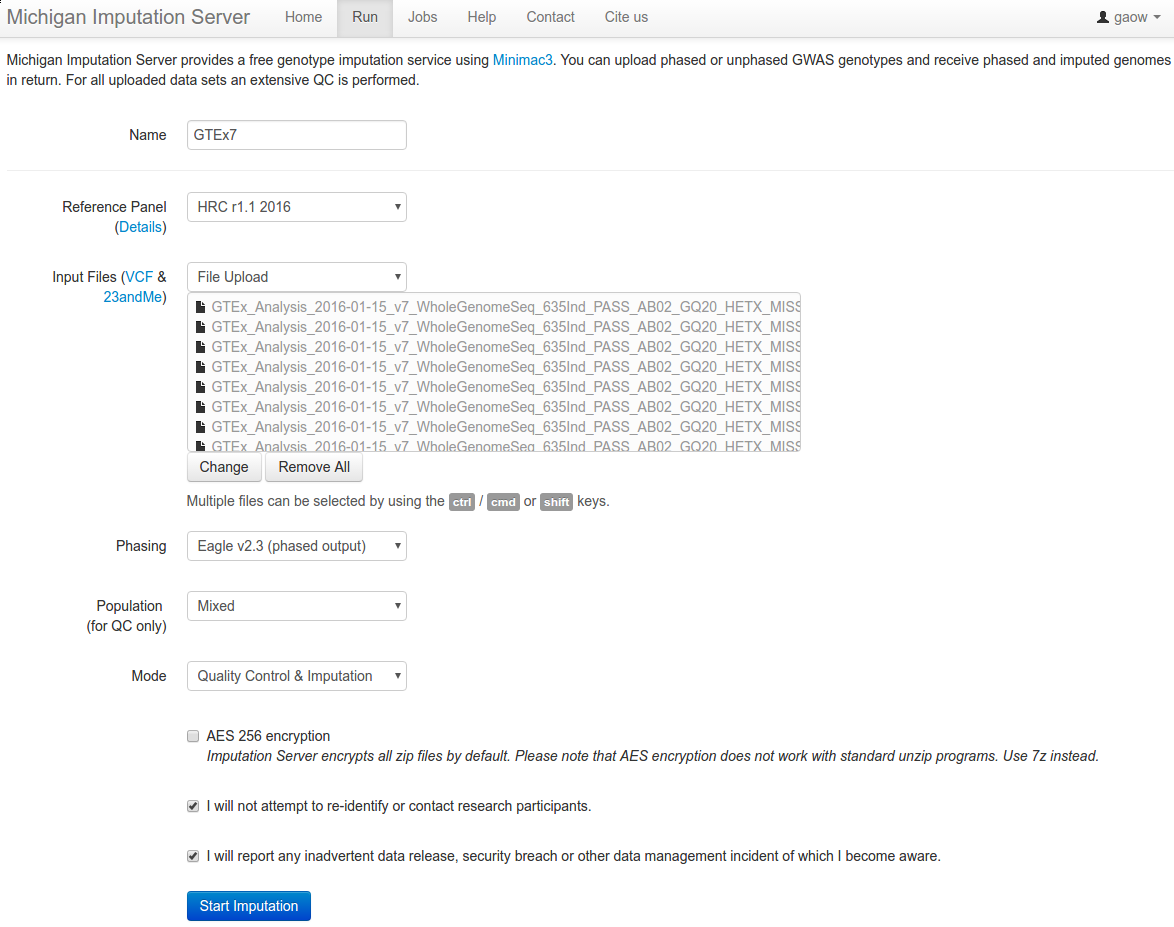

In [2]:
%preview img/UMichImputation.png

### Outcome

In [3]:
%preview img/UMichImputationResult.pdf

> img/UMichImputationResult.pdf (256.5 KiB):

## Imputation result summary

We want to compare the imputation result with the original data to address the following questions:

1. Overlap between original and imputated, and focus on why some are filtered out
2. Filter imputated data removing all imputed sites; also filter by MAF
3. Filter out data having >5% missing in the original
4. Are genotype prediction done for genotypes that are called?
5. Summary of uncertainty in imputed SNPs

Below are answers to these points. [FIXME: to be completed]

In [1]:
%sessioninfo

SoS Version,0.9.8.10
